In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from utils import set_seed
import sys
set_seed(3407)
import pylab as plt
import pandas as pd

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2024-04-29 16:05:18.969722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 16:05:19.131667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-29 16:05:19.131689: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-29 16:05:19.720621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [3]:
import pickle

class TabularRegressionData(Dataset):
    """ 
    Simple tabular data with 5 numerical features and 1 numerical response. 
    """

    def __init__(self, split, dimensions = 5):
        assert split in {'train', 'test'}
        self.split = split
        self.dimensions = dimensions
        
    def __len__(self):
        return 10000 # ...
    
    def __getitem__(self, idx):
        x = torch.randn(5)
        y = -3.15 + x[0] + (2 * x[2] * x[3]) - 3 * (x[4]**3)
        x, y
        return x, y


In [4]:
class CSVLoader(Dataset):
    def __init__(self, file_path, feature_cols, target_col, dimensions = 5):
        """
        Args:
            file_path (str): Path to the CSV file.
            feature_cols (list of str): List of column names to be used as features.
            target_col (str): Column name of the target variable.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(file_path)
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.dimensions = dimensions
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = torch.tensor(self.data_frame.loc[idx, self.feature_cols].values.astype('float32'))
        target = torch.tensor(self.data_frame.loc[idx, self.target_col], dtype = torch.float32)
        return features, target



In [5]:
# print an example instance of the dataset
train_dataset = TabularRegressionData('train')
# train_dataset = CSVLoader(
#         file_path='/home/suhas/research/dl/training_data.txt',  # Specify your CSV file path here
#         feature_cols=['x0','x1','x2','x3','x4'],  # Specify the feature column names
#         target_col='y'  # Specify the target column name
#     )

test_dataset = TabularRegressionData('test')
x, y = train_dataset[0]
print(x, y)
x1, y1 = test_dataset[0]
print(x1, y1)


tensor([ 1.0971,  0.5328, -0.3311, -0.4458,  0.6679]) tensor(-2.6515)
tensor([ 0.7001, -0.8284,  2.1086, -1.0221, -1.3357]) tensor(0.3886)


In [6]:
len(train_dataset), len(test_dataset)

(10000, 10000)

In [7]:
sys.getsizeof(train_dataset), sys.getsizeof(test_dataset)

(48, 48)

In [8]:
x1.dtype, x.dtype, y1.dtype, y.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [9]:
# create a GPT instance
from model_ff import ffmodel

model_config = ffmodel.get_default_config()
model_config.input_size = 5
model_config.use_dropout = False
model_config.p_drop = 0.1
model = ffmodel(model_config)

In [10]:
# create a Trainer object
from trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 3e-2 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
train_config.batch_size = 100
train_config.eval_iters = 100
train_config.resume = True
train_config.checkpoint_path = '/home/suhas/research/dl/checkpoints/_iters_1000.pth'
trainer = Trainer(train_config, model, train_dataset, test_dataset)

running on device cpu


In [11]:
# def batch_end_callback(trainer):
#     if trainer.iter_num % 100 == 0:
#         print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        
# #trainer.set_callback('on_batch_end', batch_end_callback)

In [12]:
trainer.run()

Resuming training from epoch 1001
iter_num 1100  train_loss: 3.7251832 , test_loss:  3.9212885 , last batch loss: 2.0260071754455566
iter_num 1200  train_loss: 3.5836403 , test_loss:  3.9835844 , last batch loss: 0.9698214530944824
iter_num 1300  train_loss: 4.1674914 , test_loss:  3.6433532 , last batch loss: 3.3911638259887695
iter_num 1400  train_loss: 3.769468 , test_loss:  2.976669 , last batch loss: 1.015846610069275
iter_num 1500  train_loss: 2.3772748 , test_loss:  4.0656524 , last batch loss: 7.6219048500061035
Directory already exists at /home/suhas/research/dl/checkpoints/_iters_1000.pth
Checkpoint saved at iter 1500
iter_num 1600  train_loss: 4.84147 , test_loss:  5.4216304 , last batch loss: 1.16587233543396
iter_num 1700  train_loss: 5.405372 , test_loss:  5.7185664 , last batch loss: 4.078228950500488
iter_num 1800  train_loss: 2.2733824 , test_loss:  3.2556195 , last batch loss: 1.1255638599395752
iter_num 1900  train_loss: 3.1175163 , test_loss:  4.986443 , last batch 

In [13]:
dftrain = pd.DataFrame(trainer.train_losses)
dftrain.columns = ['batches','loss']

dftest = pd.DataFrame(trainer.test_losses)
dftest.columns = ['batches','loss']

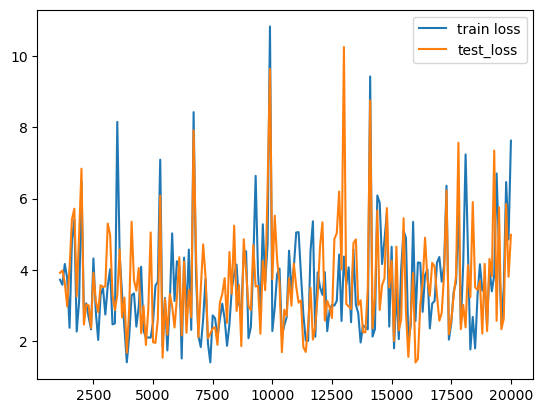

In [14]:
plt.plot(list(dftrain.batches), list(dftrain.loss))
plt.plot(list(dftest.batches), list(dftest.loss))
plt.legend(['train loss','test_loss'])